# SIS Model Simulation on Complex Networks (Monte Carlo)

## Table of Contents
0. Initial Setup
1. Utility Functions
2. Network Generation
3. Transient Validation (Test Section)
4. SIS Monte Carlo Simulation
5. Visualization and Analysis
6. Observations: Comparison between ER and BA Networks
7. MMCA comparison
8. Observations: Comparison with MMCA Theory


## 0. Initial Setup

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import os
from joblib import Parallel, delayed

# Ensure folders for saving outputs
os.makedirs("plots", exist_ok=True)
os.makedirs("results", exist_ok=True)


## 1. Utility Functions

In [3]:
def generate_er_network(N, avg_k, seed=None):
    """
    Generate an Erdős-Rényi network with average degree avg_k.

    Parameters:
        N (int): Number of nodes
        avg_k (float): Desired average degree
        seed (int): Optional random seed

    Returns:
        G (networkx.Graph): The generated ER network
    """
    p = avg_k / (N - 1)
    return nx.erdos_renyi_graph(N, p, seed=seed)


In [4]:
def generate_ba_network(N, avg_k, seed=None):
    """
    Generate a Barabási-Albert network with average degree avg_k.

    Parameters:
        N (int): Number of nodes
        avg_k (float): Desired average degree (must be >=2)
        seed (int): Optional random seed

    Returns:
        G (networkx.Graph): The generated BA network
    """
    m = int(avg_k / 2)  # Each new node connects to m existing ones
    return nx.barabasi_albert_graph(N, m, seed=seed)


In [5]:
def initialize_infection(G, rho0):
    """
    Infect a fraction rho0 of nodes in the graph.

    Parameters:
        G (networkx.Graph): The network
        rho0 (float): Initial infected fraction

    Returns:
        dict: Node state dictionary {node: 'I' or 'S'}
    """
    states = {node: 'S' for node in G.nodes()}
    initial_infected = random.sample(list(G.nodes()), int(rho0 * len(G)))
    for node in initial_infected:
        states[node] = 'I'
    return states


In [6]:
def simulate_sis_montecarlo(G, lambda_, mu, Tmax=1000, Ttrans=900, rho0=0.2):
    """
    Perform a single SIS Monte Carlo simulation.

    Parameters:
        G (networkx.Graph): Network on which to simulate
        lambda_ (float): Infection probability
        mu (float): Recovery probability
        Tmax (int): Total number of time steps (default 1000)
        Ttrans (int): Number of transient steps to discard (default 900)
        rho0 (float): Initial fraction of infected nodes (default 0.2)

    Returns:
        float: Average fraction of infected nodes (after transients)
    """
    states = initialize_infection(G, rho0)
    N = G.number_of_nodes()
    rho_over_time = []

    for t in range(Tmax):
        new_states = states.copy()
        for node in G.nodes():
            if states[node] == 'I':
                if random.random() < mu:
                    new_states[node] = 'S'
            elif states[node] == 'S':
                for neighbor in G.neighbors(node):
                    if states[neighbor] == 'I' and random.random() < lambda_:
                        new_states[node] = 'I'
                        break
        states = new_states
        rho = sum(1 for s in states.values() if s == 'I') / N
        rho_over_time.append(rho)

    # Remove transient part and compute mean
    rho_after_trans = rho_over_time[Ttrans:]
    avg_rho = np.mean(rho_after_trans)
    return avg_rho


In [7]:
def plot_rho_time_series(G, lambda_, mu, Tmax=1000, rho0=0.2):
    """
    Simula una sola dinamica SIS su una rete e plottare ρ(t) per analizzare il comportamento nel tempo.

    Parametri:
    - G: grafo NetworkX
    - lambda_: probabilità di infezione
    - mu: probabilità di guarigione
    - Tmax: numero massimo di passi temporali
    - rho0: frazione iniziale di nodi infetti
    """
    states = initialize_infection(G, rho0)
    N = G.number_of_nodes()
    rho_series = []

    for t in range(Tmax):
        infected_nodes = [node for node in G.nodes() if states[node] == 'I']
        rho_series.append(len(infected_nodes) / N)

        new_states = states.copy()
        for node in G.nodes():
            if states[node] == 'I':
                if random.random() < mu:
                    new_states[node] = 'S'
            elif states[node] == 'S':
                neighbors = list(G.neighbors(node))
                for neighbor in neighbors:
                    if states[neighbor] == 'I' and random.random() < lambda_:
                        new_states[node] = 'I'
                        break
        states = new_states

    plt.figure(figsize=(9, 4))
    plt.plot(range(Tmax), rho_series, color='blue')
    plt.xlabel("Time step")
    plt.ylabel("Infected fraction ρ(t)")
    plt.title(f"ρ(t) for λ={lambda_}, μ={mu}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
def average_sis_over_repetitions(G, lambda_, mu, Tmax=1000, Ttrans=900, rho0=0.2, n_simulations=50):
    """
    Perform multiple SIS Monte Carlo simulations and average the results.

    Parameters:
        G (networkx.Graph): Network on which to simulate
        lambda_ (float): Infection probability
        mu (float): Recovery probability
        Tmax (int): Total number of time steps (default 1000)
        Ttrans (int): Number of transient steps to discard (default 900)
        rho0 (float): Initial fraction of infected nodes (default 0.2)
        n_simulations (int): Number of independent simulations (default 100)

    Returns:
        float: Mean of average infected fractions over all simulations
    """
    rho_values = []
    for _ in range(n_simulations):
        avg_rho = simulate_sis_montecarlo(G, lambda_, mu, Tmax, Ttrans, rho0)
        rho_values.append(avg_rho)
    return np.mean(rho_values)


In [9]:
def average_sis_over_repetitions_parallel(G, lambda_, mu, Tmax=1000, Ttrans=900, rho0=0.2, n_simulations=100, n_jobs=-1):
    """
    Parallelized version of multiple SIS Monte Carlo simulations.

    Parameters:
        G (networkx.Graph): Network
        lambda_ (float): Infection probability
        mu (float): Recovery probability
        Tmax (int): Total time steps
        Ttrans (int): Transient steps to discard
        rho0 (float): Initial infected fraction
        n_simulations (int): Number of simulations
        n_jobs (int): Number of parallel jobs (-1 = use all cores)

    Returns:
        float: Mean infected fraction
    """
    results = Parallel(n_jobs=n_jobs)(
        delayed(simulate_sis_montecarlo)(G, lambda_, mu, Tmax, Ttrans, rho0)
        for _ in range(n_simulations)
    )
    return np.mean(results)

In [10]:
def compute_rho_curve(G, mu, lambda_start=0.0, lambda_end=0.3, lambda_step=0.01, Tmax=1000, Ttrans=900, rho0=0.2, n_simulations=100):
    """
    Compute the average infected fraction rho for multiple values of lambda.

    Parameters:
        G (networkx.Graph): Network on which to simulate
        mu (float): Recovery probability
        lambda_start (float): Starting value of lambda (default 0.0)
        lambda_end (float): Ending value of lambda (default 0.3)
        lambda_step (float): Step size for lambda (default 0.01)
        Tmax (int): Total number of time steps (default 1000)
        Ttrans (int): Number of transient steps to discard (default 900)
        rho0 (float): Initial fraction of infected nodes (default 0.2)
        n_simulations (int): Number of independent simulations per lambda (default 100)

    Returns:
        tuple: (lambda_values, rho_values) where each is a list of floats
    """
    lambda_values = np.arange(lambda_start, lambda_end + lambda_step, lambda_step)
    rho_values = []
    for lambda_ in lambda_values:
        rho = average_sis_over_repetitions(G, lambda_, mu, Tmax, Ttrans, rho0, n_simulations)
        rho_values.append(rho)
    return lambda_values, rho_values


In [11]:
def compute_rho_curve_parallel(G, mu, lambda_start=0.0, lambda_end=0.3, lambda_step=0.01, Tmax=1000, Ttrans=900, rho0=0.2, n_simulations=100, n_jobs=-1):
    """
    Parallel version of compute_rho_curve using joblib for multiple λ.

    Parameters:
        G (networkx.Graph): Network
        mu (float): Recovery probability
        lambda_start (float): Starting value of lambda
        lambda_end (float): Ending value of lambda
        lambda_step (float): Step size for lambda
        Tmax (int): Total number of time steps
        Ttrans (int): Number of transient steps to discard
        rho0 (float): Initial infected fraction
        n_simulations (int): Number of simulations per λ
        n_jobs (int): Number of parallel jobs (-1 = all cores)

    Returns:
        tuple: (lambda_values, rho_values)
    """
    lambda_values = np.arange(lambda_start, lambda_end + lambda_step, lambda_step)
    results = Parallel(n_jobs=n_jobs)(
        delayed(average_sis_over_repetitions_parallel)(G, l, mu, Tmax, Ttrans, rho0, n_simulations, n_jobs=-1)
        for l in lambda_values
    )
    return lambda_values, results


The function `mmca_sis_prevalence` implements the Microscopic Markov Chain Approach (MMCA) equations for the SIS model in discrete time.

The update rule for the probability that node $i$ is infected at time $t+1$ is:

$$
\rho_i^I(t+1) = (1 - \mu)\rho_i^I(t) + \left(1 - \rho_i^I(t)\right) q_i(t)
$$

where:

- $\rho_i^I(t)$ is the probability that node $i$ is infected at time $t$
- $\mu$ is the recovery probability
- $q_i(t)$ is the probability that a susceptible node $i$ gets infected by at least one of its infected neighbors, computed as:

$$
q_i(t) = 1 - \prod_{j=1}^N \left(1 - \lambda A_{ij} \rho_j^I(t) \right)
$$

with:

- $\lambda$ the infection probability
- $A_{ij}$ the adjacency matrix of the network

This implementation allows us to estimate the steady-state fraction of infected nodes, the mean of $\rho_i^I$ values, for a given network and epidemiological parameters.


In [21]:
def mmca_sis_prevalence(G, lambda_, mu, max_iter=1000):
    """
    Compute the theoretical SIS prevalence using the MMCA model (discrete-time, as per slides).
    """
    N = G.number_of_nodes()
    p = np.full(N, 0.02)  # Initial probabilities
    A = nx.to_numpy_array(G)

    for _ in range(max_iter):
        p_old = p.copy()

        # Compute the probability of infection from neighbors (discrete product)
        q = 1 - np.prod(1 - lambda_ * A * p_old, axis=1)

        # MMCA update rule
        p = (1 - mu) * p_old + (1 - p_old) * q

        if np.linalg.norm(p - p_old) < 1e-6:
            break

    return np.mean(p)

In [13]:
def compute_mmca_curve(G, mu, lambda_start=0.0, lambda_end=0.3, lambda_step=0.01):
    """
    Compute MMCA curve for different lambda values.

    Parameters:
        G (networkx.Graph): Network
        mu (float): Recovery probability
        lambda_start (float): Minimum lambda
        lambda_end (float): Maximum lambda
        lambda_step (float): Step size for lambda

    Returns:
        tuple: (lambda_values, mmca_rho_values)
    """
    lambda_values = np.arange(lambda_start, lambda_end + lambda_step, lambda_step)
    mmca_rho_values = []
    for lambda_ in lambda_values:
        rho = mmca_sis_prevalence(G, lambda_, mu)
        mmca_rho_values.append(rho)
    return lambda_values, mmca_rho_values

In [14]:
def compare_mmca_vs_simulation(rho_results, mmca_results, mu_values, save_path=None):
    """
    Plot comparison between Monte Carlo simulations and MMCA results for different networks.

    Parameters:
        rho_results (dict): {(net_name, mu): (lambda_values, rho_values)} from Monte Carlo
        mmca_results (dict): {(net_name, mu): (lambda_values, rho_values)} from MMCA
        mu_values (list): List of mu values to consider
        save_path (str or None): Optional path to save plots
    """
    # Define consistent colors per network
    color_map = {
        "ER_k4": "blue",
        "ER_k6": "green",
        "BA_k4": "orange",
        "BA_k6": "red"
    }

    for mu in mu_values:
        plt.figure(figsize=(10, 6))
        for net_name in color_map:
            lambda_sim, rho_sim = rho_results[(net_name, mu)]
            lambda_theory, rho_theory = mmca_results[(net_name, mu)]

            color = color_map[net_name]

            # Monte Carlo: line with markers
            plt.plot(lambda_sim, rho_sim, label=f"{net_name} (Sim)", linestyle='-', marker='o', markersize=4,
                     color=color)
            # MMCA: same color but dashed line
            plt.plot(lambda_theory, rho_theory, label=f"{net_name} (MMCA)", linestyle='--', color=color)

        plt.title(f"MMCA vs Monte Carlo (mu={mu})", fontsize=14)
        plt.xlabel("Infection Probability $\\lambda$", fontsize=13)
        plt.ylabel("Fraction Infected $\\rho$", fontsize=13)
        plt.legend()
        plt.grid(True)
        if save_path:
            plt.savefig(f"{save_path}/comparison_mmca_mu_{mu}.png", dpi=300)
        plt.show()


## 2. Network Generation
In this section, we generate the four networks that will be used to simulate the SIS epidemic process.

Each network is composed of 1000 nodes and falls into one of the following categories:

- **Erdős-Rényi (ER)** with ⟨k⟩ = 4
- **Erdős-Rényi (ER)** with ⟨k⟩ = 6
- **Barabási-Albert (BA)** with ⟨k⟩ = 4
- **Barabási-Albert (BA)** with ⟨k⟩ = 6

These networks will be used later in the simulation phase to analyze how different topological structures affect the epidemic spreading.


In [15]:
N = 1000
seed = 42

G_er_k4 = generate_er_network(N, avg_k=4, seed=seed)
G_er_k6 = generate_er_network(N, avg_k=6, seed=seed)
G_ba_k4 = generate_ba_network(N, avg_k=4, seed=seed)
G_ba_k6 = generate_ba_network(N, avg_k=6, seed=seed)


## 3. Transient Validation (Test Section)
In this optional test section, we check whether the number of transient steps is enough to reach stationarity. This is done by plotting $\rho(t)$ for one simulation.


Testing transient behavior on BA network with <k>=6


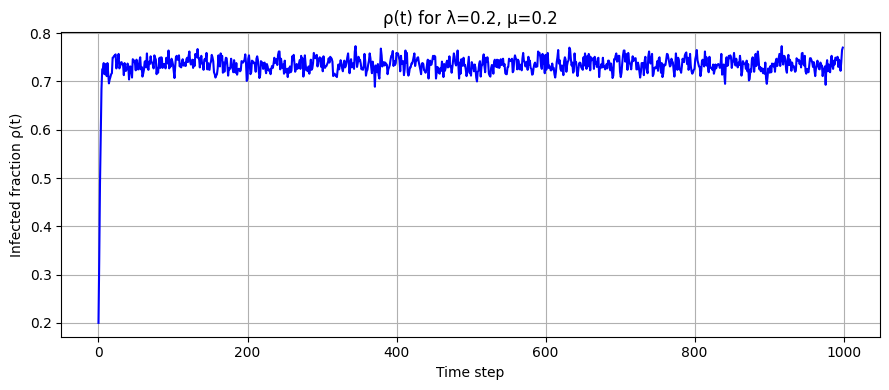

In [16]:
# Choose one example for inspection
test_mu = 0.2
test_lambda = 0.2

print("Testing transient behavior on BA network with <k>=6")
plot_rho_time_series(G_er_k6, test_lambda, test_mu, Tmax=1000, rho0=0.2)


After running several test simulations across different network configurations (both ER and BA, with varying average degrees), we observed that the infection fraction $ \rho(t) $ quickly stabilizes after only a few time steps. In most cases, the system reaches a fluctuating but stable regime well before 1000 steps.

Thus, we conclude that using $ T_{\text{trans}} = 900 $ as the length of the transient period is sufficient to discard the non-stationary phase of the simulation. The remaining 100 time steps (from $ t = 900 $ to $ t = 1000 $) are appropriate for computing the average fraction of infected nodes in the steady state.

## 4. SIS Monte Carlo Simulation

In this section, we simulate the SIS epidemic process on each of the four networks for two different recovery probabilities:

- $ \mu = 0.2 $
- $ \mu = 0.4 $

For each $ \mu $, we compute the fraction of infected nodes $ \rho $ as a function of the infection probability $ \lambda $, ranging from 0 to 0.3 with a step of 0.01. This process is repeated on the following networks:

- ER with $ \langle k \rangle = 4 $
- ER with $ \langle k \rangle = 6 $
- BA with $ \langle k \rangle = 4 $
- BA with $ \langle k \rangle = 6 $


In [17]:
mus = [0.2, 0.4]
network_dict = {
    "ER_k4": G_er_k4,
    "ER_k6": G_er_k6,
    "BA_k4": G_ba_k4,
    "BA_k6": G_ba_k6
}

rho_results = {}

for mu in mus:
    for name, G in network_dict.items():
        print(f"Simulating SIS for {name} with mu={mu}...")
        lambda_vals, rho_vals = compute_rho_curve_parallel(G, mu, lambda_start=0.0, lambda_end=0.3, lambda_step=0.01)
        rho_results[(name, mu)] = (lambda_vals, rho_vals)


Simulating SIS for ER_k4 with mu=0.2...
Simulating SIS for ER_k6 with mu=0.2...
Simulating SIS for BA_k4 with mu=0.2...
Simulating SIS for BA_k6 with mu=0.2...
Simulating SIS for ER_k4 with mu=0.4...
Simulating SIS for ER_k6 with mu=0.4...
Simulating SIS for BA_k4 with mu=0.4...
Simulating SIS for BA_k6 with mu=0.4...


## 5. Visualization and Analysis
In this section, we plot the epidemic curves $(\lambda)  $for each value of $\mu $. Each plot compares the four networks for a given $ \mu $.


In [18]:
def plot_rho_vs_lambda(rho_results, mu_values, save_path=None):
    for mu in mu_values:
        plt.figure(figsize=(8,6))
        for net_name in ["ER_k4", "ER_k6", "BA_k4", "BA_k6"]:
            lambdas, rhos = rho_results[(net_name, mu)]
            plt.plot(lambdas, rhos, label=net_name)
        plt.xlabel("Infection Probability $\\lambda$")
        plt.ylabel("Fraction of Infected Nodes $\\rho$")
        plt.title(f"SIS Epidemic Curve (mu={mu})")
        plt.legend()
        plt.grid(True)
        if save_path:
            plt.savefig(f"{save_path}/epidemic_curve_mu_{mu}.png", dpi=300)
        plt.show()


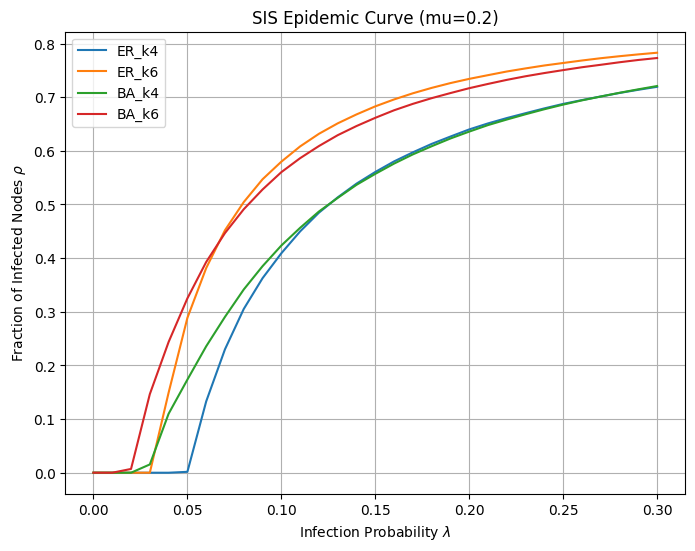

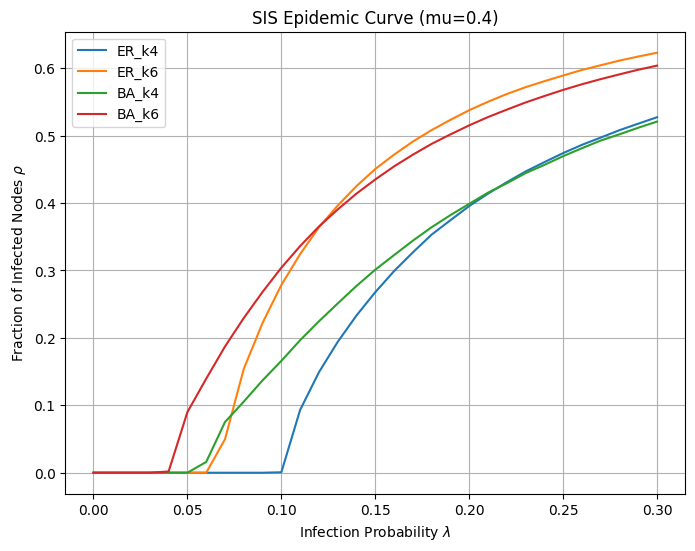

In [19]:
plot_rho_vs_lambda(rho_results, mus, save_path="plots")


## 6. Observations: Comparison between ER and BA Networks

By analyzing the epidemic curves obtained through Monte Carlo simulations, we can highlight key differences between the spread of infection in Erdős-Rényi (ER) and Barabási-Albert (BA) networks.

### Epidemic Threshold

- In **ER networks**, especially for $⟨k⟩ = 4$, we observe a **well-defined epidemic threshold**: for low values of infection probability $λ$, the fraction of infected nodes $ρ$ remains nearly zero. Only after surpassing a critical value of $λ$, the infection manages to spread significantly.
- In **BA networks**, the **threshold is much lower**, and even for very small values of $λ$, the fraction of infected nodes $ρ$ becomes positive. This is due to the presence of **hubs**, highly connected nodes that facilitate the transmission of infection even with low infection probabilities.

### Infection Level

- For the same $λ$, the fraction of infected nodes $ρ$ is **higher in BA networks** than in ER networks.

### Effect of Mean Degree $⟨k⟩$

- Increasing the mean degree from $⟨k⟩ = 4$ to $⟨k⟩ = 6$ lowers the epidemic threshold and increases the value of $ρ$ in both ER and BA networks. This is expected, indeed more average contacts lead to a higher probability of infection.

### Effect of Recovery Probability $μ$

- With $μ = 0.2$, infected individuals remain contagious for longer leading to higher values of $ρ$.
- With $μ = 0.4$, recovery is faster and the epidemic spreads less, leading to a lower $ρ$.

In conclusion, **BA networks** are more vulnerable to epidemic outbreaks than **ER networks**.



## 7. MMCA Comparison

In this section, we compare the results obtained through Monte Carlo simulations with the theoretical predictions of the Microscopic Markov Chain Approach (MMCA). MMCA is a discrete-time, mean-field approximation method that allows us to estimate the steady-state fraction of infected nodes $ \rho $ in a network.

The goal is to evaluate whether MMCA can reliably predict the epidemic threshold and the shape of the epidemic curve for different network topologies and recovery probabilities.

For each of the four networks and for each value of $ \mu \in \{0.2, 0.4\} $, we compute the theoretical epidemic curve $ \rho(\lambda) $ using the MMCA model and compare it to the Monte Carlo results obtained in Section 3.



In [22]:
mmca_results = {}
for mu in mus:
    for name, G in network_dict.items():
        print(f"Computing MMCA for {name} with mu={mu}...")
        lambda_vals, mmca_rhos = compute_mmca_curve(G, mu, lambda_start=0.0, lambda_end=0.3, lambda_step=0.01)
        mmca_results[(name, mu)] = (lambda_vals, mmca_rhos)

Computing MMCA for ER_k4 with mu=0.2...
Computing MMCA for ER_k6 with mu=0.2...
Computing MMCA for BA_k4 with mu=0.2...
Computing MMCA for BA_k6 with mu=0.2...
Computing MMCA for ER_k4 with mu=0.4...
Computing MMCA for ER_k6 with mu=0.4...
Computing MMCA for BA_k4 with mu=0.4...
Computing MMCA for BA_k6 with mu=0.4...


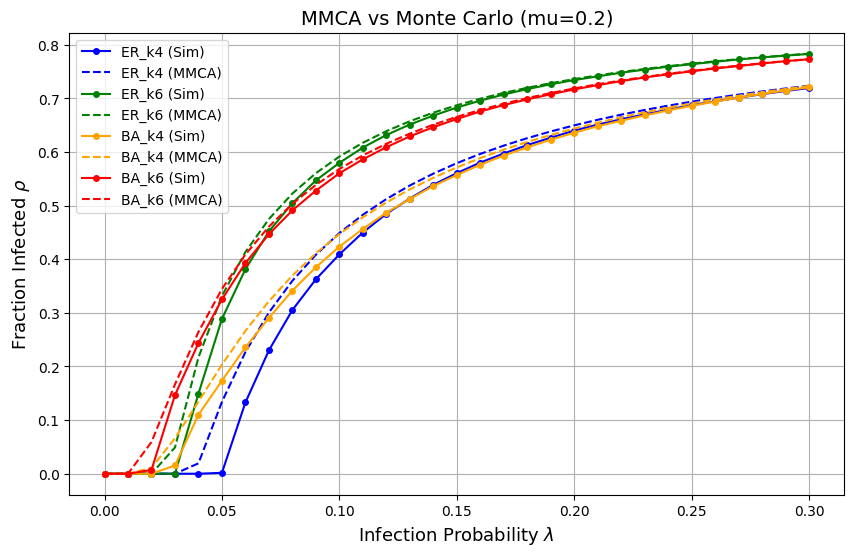

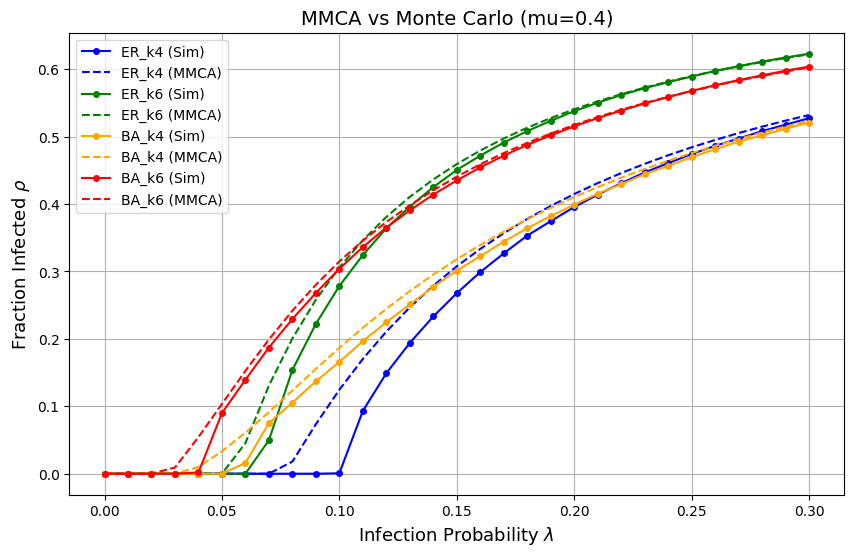

In [23]:
compare_mmca_vs_simulation(rho_results, mmca_results, mus, save_path="plots")

## 8. Observations: Comparison with MMCA Theory

By comparing the simulation results with the theoretical predictions obtained using the **Microscopic Markov Chain Approach (MMCA)**, we can draw the following observations:

- The MMCA curves **closely match** those obtained from Monte Carlo simulations.
- This agreement holds across **all network types** (ER and BA) and for **both values of** $ \mu $ (0.2 and 0.4), indicating that MMCA effectively reproduces the infection dynamics.